# acta paper -- a bunch of simulations
This notebook generates data for the acta acustica paper.

In [18]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

font={
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 11,
}

plt.rcParams.update(font)

base_dir = os.path.join(os.getcwd(), "resources")

## Infinite diffuse plane

In [2]:
def run_energy_diff_specular_ratio(
        width, length, patch_size, source, receiver):
    """
    Calculate the ratio of diffuse to specular energy for an plane.
    The plane is located in the x-y plane. Its center is at (0, 0, 0).

    Parameters
    ----------
    width : float
        Width of the plane.
    length : float
        length of the plane.
    patch_size : float
        Size of the patches.
    source : pf.Coordinates
        Position of the source.
    receiver : pf.Coordinates
        Position of the receiver in cartesian.

    Returns
    -------
    ratio : float
        Ratio of diffuse to specular energy.
    """
    source_is = source.copy()
    source_is.z *= -1
    reflection_len =  (receiver - source_is).radius[0]
    speed_of_sound = 343
    sampling_rate = 1
    etc_duration = reflection_len/speed_of_sound
    etc_duration=1

    plane = sp.geometry.Polygon(
            [[-width/2, -length/2, 0],
             [width/2, -length/2, 0],
             [width/2, length/2, 0],
             [-width/2, length/2, 0]],
            [1, 0, 0], [0, 0, 1])

    #simulation parameters
    radi = sp.DirectionalRadiosityFast.from_polygon(
        [plane], patch_size)

    brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
    brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(1, [100]),
        pf.FrequencyData(0, [100]),
    )

    radi.set_wall_brdf(
        np.arange(1), brdf, brdf_sources, brdf_receivers)

    # set air absorption
    radi.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies))

    # initialize source energy at each patch
    radi.init_source_energy(source)

    # gather energy at receiver
    radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=1/sampling_rate,
        etc_duration=etc_duration,
        max_reflection_order=0)

    I_diffuse = radi.collect_energy_receiver_mono(receiver)

    I_specular = 1/(4*np.pi*reflection_len**2)
    return np.sum(I_diffuse.time)/I_specular

In [15]:
width=100
depth=100
patch_sizes = 100/np.array([1,2,5,10,20,50,100])
print(patch_sizes)


[100.  50.  20.  10.   5.   2.   1.]


In [ ]:
err1 = []
ratio1=[]
t1=[]
# colocated s-r
source = pf.Coordinates(0, 0, 2, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
for patch_size in patch_sizes:
    print(patch_size)
    t0 = time.time()
    ratio1.append(run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver))
    t1.append(time.time()-t0)

print(ratio1)

err1 = 100*(2-ratio1)/2

print(f'Colocated s-r relative error: {err1:.2f}%')
print(f'runtimes: {t1:.2f}%')


100.0
50.0
20.0
10.0
5.0
2.0
1.0


In [30]:
# same normal
source = pf.Coordinates(0, 0, 1, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
ratio2 = run_energy_diff_specular_ratio(
    width, depth, patch_size, source, receiver)
err2=100*(2-ratio2)/2
print(ratio2)

print(f'On-normal s-r relative error: {err2:.2f}%')

1.939486535093248
On-normal s-r relative error: 3.03%


In [31]:
theta = np.deg2rad(np.arange(5,90,5))
ratio3 = np.zeros_like(theta)

for i,th in enumerate(theta):
    source = pf.Coordinates.from_spherical_colatitude(
        0, th, 2/np.cos(th), weights=1)
    receiver = pf.Coordinates.from_spherical_colatitude(
        np.pi, th, 2/np.cos(th), weights=1)
    ratio3[i] = run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver)

err3 = 100 * (2*np.cos(theta)-ratio3) / (2*np.cos(theta))

KeyboardInterrupt: 

In [ ]:
print('Same-height s-r relative error')
for i,e in enumerate(err3):
    print('\\hline')
    print(f'{np.rad2deg(theta[i]):.0f}º & {2*np.cos(theta[i]):.3f} & {ratio3[i]:.3f} & {(2*np.cos(theta[i])-ratio3[i]):.3f} & {e:.4f}% \\\\')


Same-height s-r relative error
\hline
5º & 1.992 & 1.959 & 0.033 & 1.6724% \\
\hline
10º & 1.970 & 1.939 & 0.030 & 1.5450% \\
\hline
15º & 1.932 & 1.906 & 0.026 & 1.3449% \\
\hline
20º & 1.879 & 1.859 & 0.020 & 1.0892% \\
\hline
25º & 1.813 & 1.798 & 0.015 & 0.8000% \\
\hline
30º & 1.732 & 1.723 & 0.009 & 0.5020% \\
\hline
35º & 1.638 & 1.635 & 0.004 & 0.2201% \\
\hline
40º & 1.532 & 1.532 & -0.000 & -0.0234% \\
\hline
45º & 1.414 & 1.417 & -0.003 & -0.2111% \\
\hline
50º & 1.286 & 1.290 & -0.004 & -0.3330% \\
\hline
55º & 1.147 & 1.152 & -0.004 & -0.3871% \\
\hline
60º & 1.000 & 1.004 & -0.004 & -0.3798% \\
\hline
65º & 0.845 & 0.848 & -0.003 & -0.3237% \\
\hline
70º & 0.684 & 0.686 & -0.002 & -0.2347% \\
\hline
75º & 0.518 & 0.518 & -0.001 & -0.1248% \\
\hline
80º & 0.347 & 0.347 & 0.000 & 0.0323% \\
\hline
85º & 0.174 & 0.173 & 0.002 & 1.0207% \\


C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_5352\2814586789.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure[0].show()
C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_5352\2814586789.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure[0].show()


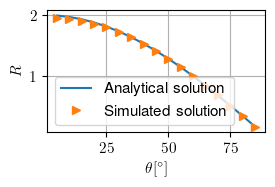

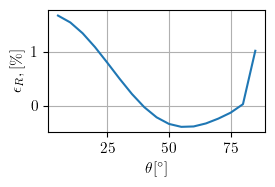

In [ ]:
figure = plt.subplots(figsize=(3,2))
plt.plot(theta/np.pi*180,2*np.cos(theta))
plt.plot(theta/np.pi*180,ratio3,'>')
plt.xlabel('$$\\theta [^{\circ}]$$')
plt.ylabel('$$R$$')
plt.grid()
plt.tight_layout()
plt.legend(['Analytical solution','Simulated solution'])
figure[0].show()
figure[0].savefig('D:\\Joao_Fatela\\phd\\Papers\\Internoise_2025\\figures\\infplane_raw.pdf')

figure = plt.subplots(figsize=(3,2))
plt.plot(theta/np.pi*180,err3)
plt.xlabel('$$\\theta [^{\circ}]$$')
plt.ylabel('$$\epsilon_R,[\%]$$')
plt.grid()
plt.tight_layout()
figure[0].show()
figure[0].savefig('D:\\Joao_Fatela\\phd\\Papers\\Internoise_2025\\figures\\infplane_err.pdf')